<a href="https://colab.research.google.com/github/415400396/-/blob/master/TSAnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
MODEL_SELECTED = "lstmae" # Possible Values ['deepant', 'lstmae']
LOOKBACK_SIZE = 20
DIMENSION = 3
EPOCH = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def data_pre_processing(df):
    """
        Data pre-processing : Function to create data for Model
    """
    try:
        scaled_data = MinMaxScaler(feature_range = (0, 1))
        data_scaled_ = scaled_data.fit_transform(df)
        df.loc[:,:] = data_scaled_
        _data_ = df.to_numpy(copy=True)
        X = np.zeros(shape=(df.shape[0]-LOOKBACK_SIZE,LOOKBACK_SIZE,df.shape[1]))
        Y = np.zeros(shape=(df.shape[0]-LOOKBACK_SIZE,df.shape[1]))
        timesteps = []
        for i in range(LOOKBACK_SIZE-1, df.shape[0]-1):
            timesteps.append(df.index[i])
            Y[i-LOOKBACK_SIZE+1] = _data_[i+1]
            for j in range(i-LOOKBACK_SIZE+1, i+1):
                X[i-LOOKBACK_SIZE+1][LOOKBACK_SIZE-1-i+j] = _data_[j]
        return X,Y,timesteps
    except Exception as e:
        print("Error while performing data pre-processing : {0}".format(e))
        return None, None, None

In [ ]:
class DeepAnT(torch.nn.Module):
    """
        Model : Class for DeepAnT model
    """
    def __init__(self, LOOKBACK_SIZE, DIMENSION):
        super(DeepAnT, self).__init__()
        self.conv1d_1_layer = torch.nn.Conv1d(in_channels=LOOKBACK_SIZE, out_channels=16, kernel_size=3)
        self.relu_1_layer = torch.nn.ReLU()
        self.maxpooling_1_layer = torch.nn.MaxPool1d(kernel_size=2)
        self.conv1d_2_layer = torch.nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3)
        self.relu_2_layer = torch.nn.ReLU()
        self.maxpooling_2_layer = torch.nn.MaxPool1d(kernel_size=2)
        self.flatten_layer = torch.nn.Flatten()
        self.dense_1_layer = torch.nn.Linear(80, 40)
        self.relu_3_layer = torch.nn.ReLU()
        self.dropout_layer = torch.nn.Dropout(p=0.25)
        self.dense_2_layer = torch.nn.Linear(40, DIMENSION)
        
    def forward(self, x):
        x = self.conv1d_1_layer(x)
        x = self.relu_1_layer(x)
        x = self.maxpooling_1_layer(x)
        x = self.conv1d_2_layer(x)
        x = self.relu_2_layer(x)
        x = self.maxpooling_2_layer(x)
        x = self.flatten_layer(x)
        x = self.dense_1_layer(x)
        x = self.relu_3_layer(x)
        x = self.dropout_layer(x)
        return self.dense_2_layer(x)

In [ ]:
class LSTMAE(torch.nn.Module):
    """
        Model : Class for LSTMAE model
    """
    def __init__(self, LOOKBACK_SIZE, DIMENSION):
        super(LSTMAE, self).__init__()
        self.lstm_1_layer = torch.nn.LSTM(DIMENSION, 128, 1)
        self.dropout_1_layer = torch.nn.Dropout(p=0.2)
        self.lstm_2_layer = torch.nn.LSTM(128, 64, 1)
        self.dropout_2_layer = torch.nn.Dropout(p=0.2)
        self.lstm_3_layer = torch.nn.LSTM(64, 64, 1)
        self.dropout_3_layer = torch.nn.Dropout(p=0.2)
        self.lstm_4_layer = torch.nn.LSTM(64, 128, 1)
        self.dropout_4_layer = torch.nn.Dropout(p=0.2)
        self.linear_layer = torch.nn.Linear(128, DIMENSION)
        
    def forward(self, x):
        x, (_,_) = self.lstm_1_layer(x)
        x = self.dropout_1_layer(x)
        x, (_,_) = self.lstm_2_layer(x)
        x = self.dropout_2_layer(x)
        x, (_,_) = self.lstm_3_layer(x)
        x = self.dropout_3_layer(x)
        x, (_,_) = self.lstm_4_layer(x)
        x = self.dropout_4_layer(x)
        return self.linear_layer(x)

In [ ]:
def make_train_step(model, loss_fn, optimizer):
    """
        Computation : Function to make batch size data iterator
    """
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(y, yhat)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

In [ ]:
def compute(X,Y):
    """
        Computation : Find Anomaly using model based computation 
    """
    if str(MODEL_SELECTED) == "lstmae":
        model = LSTMAE(LOOKBACK_SIZE,DIMENSION)
        model.to(device)
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        train_data = torch.utils.data.TensorDataset(torch.tensor(X.astype(np.float32)), torch.tensor(X.astype(np.float32)))
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=False)
        train_step = make_train_step(model, criterion, optimizer)
        for epoch in range(EPOCH):
            loss_sum = 0.0
            ctr = 0
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                loss_train = train_step(x_batch, y_batch)
                loss_sum += loss_train
                ctr += 1
            print("Training Loss: {0} - Epoch: {1}".format(float(loss_sum/ctr), epoch+1))
        hypothesis = model(torch.tensor(X.astype(np.float32)).to(device)).detach().cpu().numpy()
        loss = np.linalg.norm(hypothesis - X, axis=(1,2))
        return loss.reshape(len(loss),1)
    elif str(MODEL_SELECTED) == "deepant":
        model = DeepAnT(LOOKBACK_SIZE,DIMENSION)
        model.to(device)
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-5)
        train_data = torch.utils.data.TensorDataset(torch.tensor(X.astype(np.float32)), torch.tensor(Y.astype(np.float32)))
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=False)
        train_step = make_train_step(model, criterion, optimizer)
        for epoch in range(EPOCH):
            loss_sum = 0.0
            ctr = 0
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                loss_train = train_step(x_batch, y_batch)
                loss_sum += loss_train
                ctr += 1
            print("Training Loss: {0} - Epoch: {1}".format(float(loss_sum/ctr), epoch+1))
        hypothesis = model(torch.tensor(X.astype(np.float32)).to(device)).detach().cpu().numpy()
        loss = np.linalg.norm(hypothesis - Y, axis=1)
        return loss.reshape(len(loss),1)
    else:
        print("Selection of Model is not in the set")
        return None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
csv_path = '/content/drive/My Drive/project/data_mining/dataset.csv'
df = pd.read_csv(csv_path)
df.head()

,WindNumber,Time,WindSpeed,Power,RotorSpeed
0,1,2017/11/1 0:20,4.188333,65.750000,5.779167
1,1,2017/11/1 0:30,4.042500,120.700000,8.636500
2,1,2017/11/1 0:40,4.137368,135.157895,8.668421
3,1,2017/11/1 0:50,4.274737,157.315789,8.727895
4,1,2017/11/1 1:00,4.108947,129.894737,8.656842


In [ ]:
one_data = df.copy()
one_data = df[df['WindNumber'] == 1]

features_considered = ['WindSpeed', 'Power', 'RotorSpeed']
features = one_data[features_considered]
features.index = one_data['Time']
features.head()

,WindSpeed,Power,RotorSpeed
Time,,,
2017/11/1 0:20,4.188333,65.750000,5.779167
2017/11/1 0:30,4.042500,120.700000,8.636500
2017/11/1 0:40,4.137368,135.157895,8.668421
2017/11/1 0:50,4.274737,157.315789,8.727895
2017/11/1 1:00,4.108947,129.894737,8.656842


In [ ]:
X,Y,T = data_pre_processing(features)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
loss = compute(X, Y)

Training Loss: 0.04158706481122973 - Epoch: 1
Training Loss: 0.028892952011267525 - Epoch: 2
Training Loss: 0.02527466312764858 - Epoch: 3
Training Loss: 0.021337117537971694 - Epoch: 4
Training Loss: 0.018325718721478756 - Epoch: 5
Training Loss: 0.01640455614378894 - Epoch: 6
Training Loss: 0.014917681984806789 - Epoch: 7
Training Loss: 0.013645011962567751 - Epoch: 8
Training Loss: 0.012549904244970194 - Epoch: 9
Training Loss: 0.011621082295793148 - Epoch: 10
Training Loss: 0.010782310980769387 - Epoch: 11
Training Loss: 0.010036942974839123 - Epoch: 12
Training Loss: 0.009347402782033828 - Epoch: 13
Training Loss: 0.008669344468817015 - Epoch: 14
Training Loss: 0.008037208049164505 - Epoch: 15
Training Loss: 0.007419446711421147 - Epoch: 16
Training Loss: 0.00679159661448061 - Epoch: 17
Training Loss: 0.006177325877130547 - Epoch: 18
Training Loss: 0.005614416390743022 - Epoch: 19
Training Loss: 0.005075147522606822 - Epoch: 20
Training Loss: 0.004604842494046557 - Epoch: 21
Train

In [ ]:

loss_df = pd.DataFrame(loss, columns = ["loss"])
loss_df.index = T
loss_df.index = pd.to_datetime(loss_df.index)
loss_df["timestamp"] = T
loss_df["timestamp"] = pd.to_datetime(loss_df["timestamp"])

In [ ]:
print(loss_df.shape)
anomalyData = loss_df[loss_df['loss'] > 0.8]
print(anomalyData.shape)
loss_df.to_csv ('/content/drive/My Drive/project/data_mining/loss_1.csv', index = False, header=True)

(40707, 2)
(89, 2)


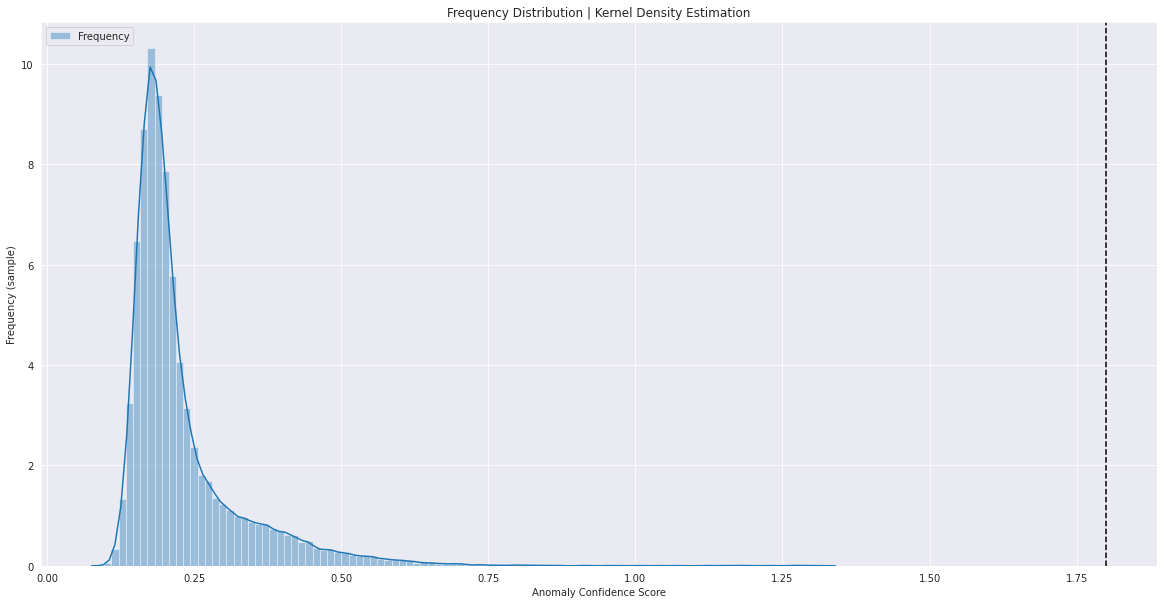

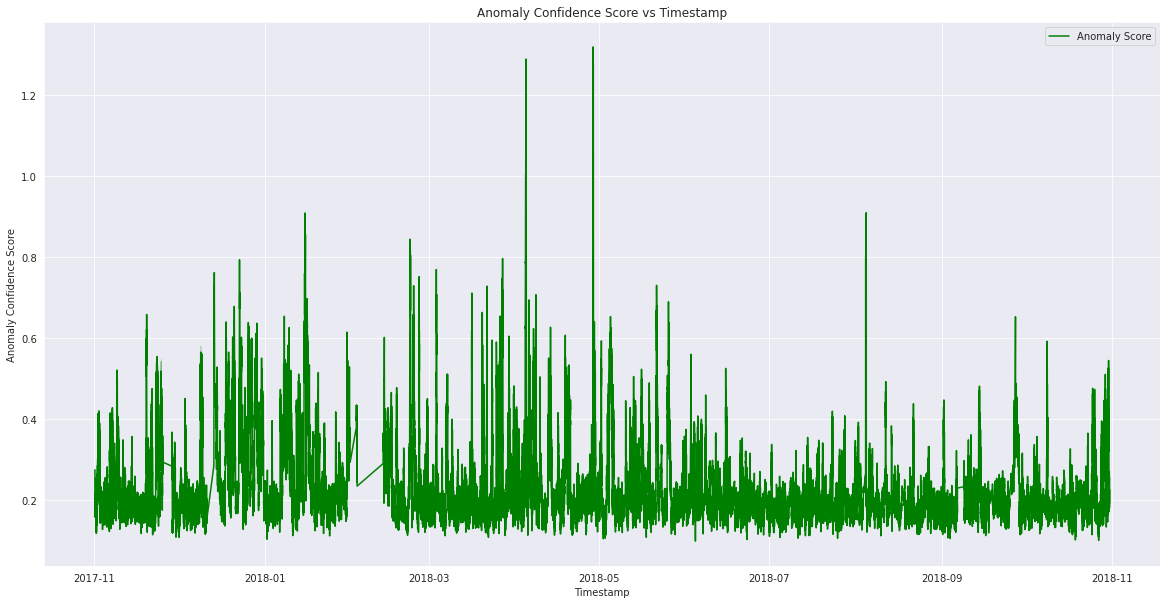

In [ ]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
ax = sns.distplot(loss_df["loss"], bins=100, label="Frequency")
ax.set_title("Frequency Distribution | Kernel Density Estimation")
ax.set(xlabel='Anomaly Confidence Score', ylabel='Frequency (sample)')
plt.axvline(1.80, color="k", linestyle="--")
plt.legend()

plt.figure(figsize=(20,10))
ax = sns.lineplot(x="timestamp", y="loss", data=loss_df, color='g', label="Anomaly Score")
ax.set_title("Anomaly Confidence Score vs Timestamp")
ax.set(ylabel="Anomaly Confidence Score", xlabel="Timestamp")
plt.legend()